In [1]:
!pip install wfdb
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 13.0 MB/s eta 0:00:0000:01



===== Fold 1 =====


Fold 1 - Epoch 25/25: 100%|██████████| 221/221 [02:56<00:00,  1.25it/s]


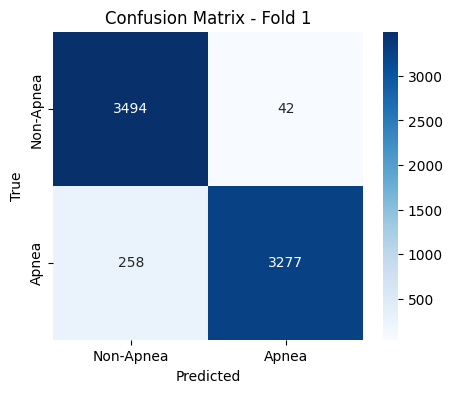

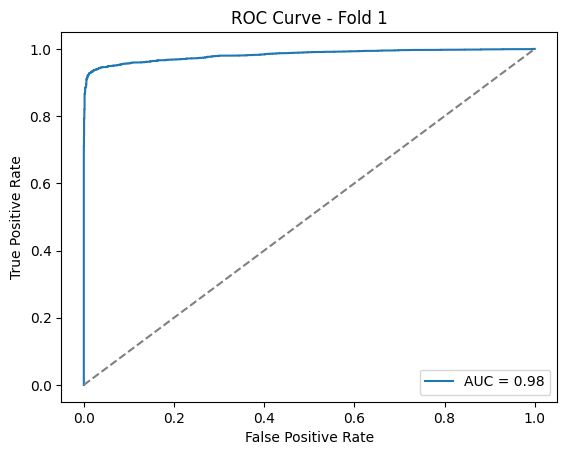

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3536
           1       0.99      0.93      0.96      3535

    accuracy                           0.96      7071
   macro avg       0.96      0.96      0.96      7071
weighted avg       0.96      0.96      0.96      7071

Fold 1: Acc=0.9576, F1=0.9562, Kappa=0.9151

===== Fold 2 =====


Fold 2 - Epoch 25/25: 100%|██████████| 221/221 [02:50<00:00,  1.30it/s]


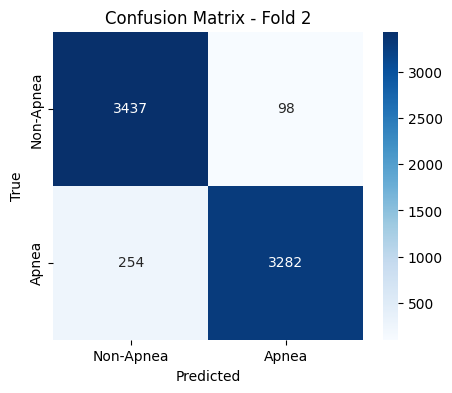

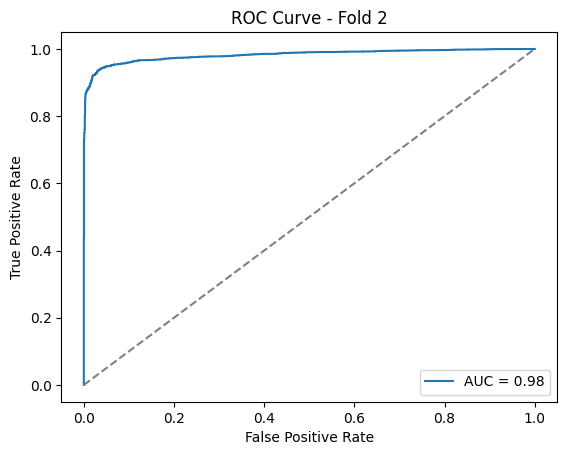

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3535
           1       0.97      0.93      0.95      3536

    accuracy                           0.95      7071
   macro avg       0.95      0.95      0.95      7071
weighted avg       0.95      0.95      0.95      7071

Fold 2: Acc=0.9502, F1=0.9491, Kappa=0.9004

==== Final Results ====
Accuracy: 0.9539 ± 0.0037
F1-score: 0.9527
Cohen’s Kappa: 0.9078


In [2]:
# ======================================================
# High-Accuracy Apnea Detection (CNN + BiLSTM + Transformer)
# Modified to use exactly TARGET_PER_CLASS samples per class (apnea / non-apnea)
# Now with Confusion Matrix and ROC Curve plots per fold
# ======================================================

import os, wfdb, numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score, classification_report,
    confusion_matrix, roc_curve, auc
)
from torch.utils.data import Dataset, DataLoader
import torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Config
# ---------------------------
DATASET_PATH = "/kaggle/input/new-sleep-apnea/apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"
ORIG_FS = 100
WIN_MIN = 10
STRIDE_MIN = 1
WIN_SIZE = ORIG_FS * 60 * WIN_MIN
STEP = ORIG_FS * 60 * STRIDE_MIN
SEQ_LEN = 300
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# For reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Target per-class count
TARGET_PER_CLASS = 7071

# ---------------------------
# Preprocessing
# ---------------------------
def bandpass(sig, fs=ORIG_FS, low=3.0, high=45.0, order=4):
    nyq = 0.5*fs
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, sig)

def detect_rpeaks(sig, fs=ORIG_FS):
    sig = sig - np.median(sig)
    th = np.median(np.abs(sig)) + 0.5*np.std(sig)
    min_dist = int(0.35*fs)
    peaks, _ = find_peaks(np.abs(sig), height=th, distance=min_dist)
    return peaks

def build_rri_ra(segment, fs=ORIG_FS):
    peaks = detect_rpeaks(segment, fs)
    if len(peaks) < 2:
        return None
    rri = np.diff(peaks) * 1000 / fs
    ra = segment[peaks[:-1]]
    return rri.astype(np.float32), ra.astype(np.float32)

def resample_seq(seq, target_len=SEQ_LEN):
    if len(seq) < 2:
        return np.zeros(target_len, dtype=np.float32)
    x_old = np.linspace(0, 1, len(seq))
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, seq, kind="linear", fill_value="extrapolate")
    return f(x_new).astype(np.float32)

def augment_signal(sig):
    if random.random() < 0.5:
        sig = sig + 0.01*np.random.randn(len(sig))
    if random.random() < 0.5:
        sig = sig * (0.9 + 0.2*np.random.rand())
    if random.random() < 0.3:
        shift = int(0.05*len(sig))
        sig = np.roll(sig, shift)
    return sig

def build_index(records):
    idx = []
    for rec in records:
        try:
            ann = wfdb.rdann(os.path.join(DATASET_PATH, rec), "apn")
            labels = ann.symbol
            total_len = wfdb.rdrecord(os.path.join(DATASET_PATH, rec)).p_signal.shape[0]
        except:
            continue
        starts = range(0, total_len - WIN_SIZE + 1, STEP)
        for s in starts:
            minute = s // (ORIG_FS * 60)
            window_labels = labels[minute:minute + WIN_MIN]
            lab = 1 if "A" in window_labels else 0
            idx.append((rec, s, lab))
    return idx

# ---------------------------
# Dataset
# ---------------------------
class ApneaDataset(Dataset):
    def __init__(self, index, seq_len=SEQ_LEN, augment=False):
        self.seq_len = seq_len
        self.augment = augment
        random.shuffle(index)
        self.index = index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        rec, s, label = self.index[idx]
        rec_path = os.path.join(DATASET_PATH, rec)
        sig = wfdb.rdrecord(rec_path).p_signal[:, 0].astype(np.float32)

        window = sig[s:s + WIN_SIZE]
        if self.augment:
            window = augment_signal(window)

        window = bandpass(window)
        result = build_rri_ra(window)

        if result is None:
            feat_seq = np.zeros((self.seq_len, 2), dtype=np.float32)
        else:
            rri, ra = result
            rri = (rri - np.mean(rri)) / (np.std(rri) + 1e-6)
            ra = (ra - np.mean(ra)) / (np.std(ra) + 1e-6)
            feat_seq = np.stack(
                [resample_seq(rri, self.seq_len),
                 resample_seq(ra, self.seq_len)],
                axis=1
            )

        return torch.from_numpy(feat_seq), torch.tensor(label, dtype=torch.long)

# ---------------------------
# Model
# ---------------------------
class BranchCNNLSTM(nn.Module):
    def __init__(self, in_ch=2, conv_ch=64, hidden=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, conv_ch, 7, padding=3), nn.ReLU(), nn.BatchNorm1d(conv_ch),
            nn.Conv1d(conv_ch, conv_ch, 5, padding=2), nn.ReLU(), nn.BatchNorm1d(conv_ch),
            nn.Conv1d(conv_ch, conv_ch, 3, padding=1), nn.ReLU(), nn.BatchNorm1d(conv_ch),
        )
        self.pool = nn.AdaptiveAvgPool1d(100)
        self.lstm = nn.LSTM(conv_ch, hidden, batch_first=True, bidirectional=True)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        _, (h, _) = self.lstm(x)
        return torch.cat([h[-2], h[-1]], dim=1)

class ApneaNet(nn.Module):
    def __init__(self, hidden=128, proj_dim=256):
        super().__init__()
        self.branch = BranchCNNLSTM(2, 64, hidden)
        self.proj = nn.Linear(hidden*2, proj_dim)
        encoder = nn.TransformerEncoderLayer(
            d_model=proj_dim, nhead=8, dim_feedforward=512, dropout=0.3, batch_first=True
        )
        self.trans = nn.TransformerEncoder(encoder, num_layers=3)
        self.fc = nn.Sequential(
            nn.Linear(proj_dim, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        bfeat = self.branch(x)
        tokens = self.proj(bfeat).unsqueeze(1)
        out = self.trans(tokens).mean(dim=1)
        return self.fc(out)

# ---------------------------
# Training / Evaluation
# ---------------------------
def train_eval(train_idx, test_idx, all_index, class_weights=None, fold=0):
    train_ds = ApneaDataset([all_index[i] for i in train_idx], augment=True)
    test_ds = ApneaDataset([all_index[i] for i in test_idx], augment=False)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    model = ApneaNet().to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

    if class_weights is not None:
        weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
        crit = nn.CrossEntropyLoss(weight=weights)
    else:
        crit = nn.CrossEntropyLoss()

    for ep in range(EPOCHS):
        model.train(); total_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Fold {fold} - Epoch {ep+1}/{EPOCHS}")
        for X, y in pbar:
            X, y = X.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(X)
            loss = crit(out, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            total_loss += loss.item()
        scheduler.step()

    # Evaluation
    model.eval(); preds, gts, probs = [], [], []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(DEVICE)
            out = model(X)
            pred = out.argmax(1).cpu().tolist()
            prob = F.softmax(out, dim=1)[:,1].cpu().numpy()
            preds += pred
            gts += y.tolist()
            probs += prob.tolist()

    acc = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds, zero_division=0)
    kappa = cohen_kappa_score(gts, preds)

    # Confusion Matrix
    cm = confusion_matrix(gts, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Apnea","Apnea"], yticklabels=["Non-Apnea","Apnea"])
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(gts, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - Fold {fold}")
    plt.legend(loc="lower right")
    plt.show()

    return acc, f1, kappa, classification_report(gts, preds, zero_division=0)

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    records = [f"a{str(i).zfill(2)}" for i in range(1, 21)]
    index = build_index(records)
    if len(index) == 0:
        raise RuntimeError("No index entries found.")

    pos_list = [x for x in index if x[2] == 1]
    neg_list = [x for x in index if x[2] == 0]

    def get_fixed_samples(lst, target, rng_seed=SEED):
        random.seed(rng_seed)
        if len(lst) >= target:
            return random.sample(lst, target)
        else:
            extra = random.choices(lst, k=(target - len(lst)))
            return lst + extra

    pos_samples = get_fixed_samples(pos_list, TARGET_PER_CLASS)
    neg_samples = get_fixed_samples(neg_list, TARGET_PER_CLASS)

    balanced_index = pos_samples + neg_samples
    random.shuffle(balanced_index)

    labels = [x[2] for x in balanced_index]
    cw = [1.0, 1.0]

    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)
    accs, f1s, kappas = [], [], []

    for fold, (train_idx, test_idx) in enumerate(skf.split(balanced_index, labels), 1):
        print(f"\n===== Fold {fold} =====")
        acc, f1, kappa, rep = train_eval(train_idx, test_idx, balanced_index, class_weights=cw, fold=fold)
        accs.append(acc); f1s.append(f1); kappas.append(kappa)
        print(rep)
        print(f"Fold {fold}: Acc={acc:.4f}, F1={f1:.4f}, Kappa={kappa:.4f}")

    print("\n==== Final Results ====")
    print(f"Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"F1-score: {np.mean(f1s):.4f}")
    print(f"Cohen’s Kappa: {np.mean(kappas):.4f}")
